# Natural Language Processing - Bill Text Exploration

**This analysis includes combined text of bill titles and summaries**

Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [3]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [2]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [3]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [4]:
df = query('SELECT * FROM con_bills.current_bills WHERE Cong >= 110')


In [5]:
df.shape

(51067, 29)

In [6]:
df.tail()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassH,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary
51062,114-S-995,s,1,114,1.0,2015-04-16 00:00:00,0,0,A bill to establish congressional trade negoti...,0,...,0,0,None,0,1,1,18.0,1802.0,https://www.congress.gov/bill/114th-congress/s...,Bipartisan Congressional Trade Priorities and ...
51063,114-S-996,s,1,114,7.0,2015-04-16 00:00:00,0,0,A bill to facilitate nationwide availability o...,0,...,0,0,None,0,1,0,13.0,1302.0,https://www.congress.gov/bill/114th-congress/s...,Volunteer Income Tax Assistance (VITA) Act
51064,114-S-997,s,1,114,1.0,2015-04-16 00:00:00,0,0,A bill to extend the authorization for the maj...,0,...,0,0,None,0,1,1,3.0,322.0,https://www.congress.gov/bill/114th-congress/s...,"Department of Veterans Affairs Construction, A..."
51065,114-S-998,s,1,114,4.0,2015-04-16 00:00:00,0,0,A bill to establish a process for the consider...,0,...,0,0,None,0,1,1,18.0,1807.0,https://www.congress.gov/bill/114th-congress/s...,American Manufacturing Competitiveness Act of ...
51066,114-S-999,s,1,114,0.0,2015-04-16 00:00:00,0,0,A bill to amend the Small Business Act to prov...,0,...,0,0,None,0,1,1,15.0,1521.0,https://www.congress.gov/bill/114th-congress/s...,Small Business Development Centers Improvement...


**Final Cleaning:**

In [7]:
df['Summary'].isnull().sum()

50

In [8]:
df['Summary'].fillna('None', inplace = True)

In [9]:
df['Summary'].isnull().sum()

0

In [10]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [11]:
# blanks = []

# for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
#     if type(summary)==str:            # avoid NaN values
#         if summary.isspace():         # test 'plot' for whitespace
#             blanks.append(i)
                  
# len(blanks)

In [12]:
df.shape

(51067, 29)

**Combine Title and Summary columns:**

In [13]:
df['combined_text'] = df[['Title', 'Summary']].astype(str).apply(' '.join, axis=1)

In [14]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


# Topic Modeling

**Split Training and Testing Data**

In [15]:
from sklearn import preprocessing

In [16]:
from sklearn.model_selection import train_test_split

X = df['combined_text']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y)

In [17]:
df['PassH'].head()

0    1
1    0
2    0
3    0
4    0
Name: PassH, dtype: int64

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

In [18]:
encoder = preprocessing.LabelEncoder()

y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

In [19]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [20]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}


In [21]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [22]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


In [23]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [24]:
test_fun = df.iloc[3586][29]
test_fun

'To accelerate the reduction of greenhouse gas emissions in the United States by establishing a market-driven system of greenhouse gas tradeable allowances that will limit greenhouse gas emissions in the United States, reduce dependence upon foreign oil, and ensure benefits to consumers from the trading in such allowances, and for other purposes. Climate Stewardship and Economic Security Act of 2007 - Requires the Administrator of the Environmental Protection Agency (EPA) to establish a National Greenhouse Gas Database consisting of: (1) an inventory of greenhouse gas (GHG) emissions by covered entities (specified entities that own or control a source of GHG emissions in the electric power, industrial, and commercial sectors of the U.S. economy that emit more than 10,000 metric tons of GHGs per year); and (2) a registry of GHG emission reductions and increased sequestration, applicable to all entities.'

In [25]:
tokenizer(test_fun)


['accelerate',
 'reduction',
 'greenhouse',
 'gas',
 'emission',
 'establish',
 'marketdriven',
 'system',
 'greenhouse',
 'gas',
 'tradeable',
 'allowance',
 'limit',
 'greenhouse',
 'gas',
 'emission',
 'reduce',
 'dependence',
 'foreign',
 'oil',
 'ensure',
 'benefit',
 'consumer',
 'trading',
 'allowance',
 'climate',
 'stewardship',
 'economic',
 'security',
 'require',
 'administrator',
 'environmental',
 'protection',
 'agency',
 'epa',
 'establish',
 'national',
 'greenhouse',
 'gas',
 'database',
 'consist',
 'inventory',
 'greenhouse',
 'gas',
 'ghg',
 'emission',
 'covered',
 'entity',
 'specify',
 'entity',
 'control',
 'source',
 'ghg',
 'emission',
 'electric',
 'power',
 'industrial',
 'commercial',
 'sector',
 'economy',
 'emit',
 'metric',
 'ton',
 'ghg',
 'year',
 'registry',
 'ghg',
 'emission',
 'reduction',
 'increase',
 'sequestration',
 'applicable',
 'entity']

**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

Explore:

min_df:

- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".

max_df: Attempt to remove heavily used words.

- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10
transformed = vectorizer.fit_transform(X, y)
print(len(vectorizer.get_feature_names()))

10000


**Exploring Stored Words**

Think about the number of words and how to decrease that list!

Lemmatization should be something to further consider, also limiting specific words (pronouns?) used often

In [27]:
len(vectorizer.get_feature_names())

10000

In [28]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 2454) #second should be len of cv
    print(vectorizer.get_feature_names()[word_id])

checkbox
conform
anonymous
admit
abraham
broadband
beginning
city
contributor
cove


**Topic - Modeling LDA**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [29]:
from sklearn.decomposition import LatentDirichletAllocation

**OPTIONAL - Grisearch LDA**

In [53]:
from sklearn.model_selection import GridSearchCV


# Define Search Param
search_params = {'n_components': [13],
                 'learning_decay': [.3],
                 'random_state': [2]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# Do the Grid Search
model.fit(transformed)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [54]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed))

#Shows best params
#shows best log likelihood
#shows model perplexity score

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 13, 'random_state': 2}
Best Log Likelihood Score:  -4453002.224204919
Model Perplexity:  957.500224494282


**Model evaluation:**

Look at model components:

In [55]:
best_lda_model.components_

array([[7.69248361e-02, 1.33196783e-01, 7.69246040e-02, ...,
        8.39427504e+00, 7.69230769e-02, 7.69237492e-02],
       [7.69231841e-02, 2.00867833e+00, 7.69231627e-02, ...,
        7.69238571e-02, 7.69278536e-02, 7.69230769e-02],
       [7.69234439e-02, 7.69233542e-02, 7.69231652e-02, ...,
        7.69233910e-02, 1.00769227e+01, 7.69230769e-02],
       ...,
       [1.20769153e+01, 1.12520009e+01, 7.69231237e-02, ...,
        2.56766288e-01, 7.69232750e-02, 7.69230769e-02],
       [7.69230769e-02, 5.90472955e+01, 7.69243560e-02, ...,
        2.58180257e+02, 7.69289197e-02, 7.69241609e-02],
       [7.69230769e-02, 7.69233664e-02, 7.69255997e-02, ...,
        7.69234406e-02, 7.69233618e-02, 7.69230769e-02]])

In [56]:
single_topic = best_lda_model.components_[0]

In [57]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([6485, 1468, 7860, ..., 7160, 8140, 5060])

In [58]:
# Word least representative of this topic
single_topic[1279]


0.9787192149504518

In [59]:
# Word most representative of this topic
single_topic[7710]

0.07692820933168064

Look at the top fifteen for each topic:

In [60]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['information', 'employee', 'certain', 'code', 'right', 'foreign', 'immigration', 'homeland', 'require', 'criminal', 'enforcement', 'person', 'prohibit', 'security', 'law']


THE TOP 15 WORDS FOR TOPIC #1
['exchange', 'establish', 'use', 'production', 'require', 'security', 'renewable', 'policy', 'commission', 'oil', 'fuel', 'gas', 'product', 'consumer', 'energy']


THE TOP 15 WORDS FOR TOPIC #2
['family', 'title', 'va', 'affair', 'facility', 'health', 'affairs', 'service', 'medical', 'child', 'veteran', 'program', 'department', 'veterans', 'care']


THE TOP 15 WORDS FOR TOPIC #3
['amends', 'hospital', 'benefit', 'insurance', 'medicaid', 'payment', 'service', 'xviii', 'program', 'small', 'business', 'medicare', 'title', 'social', 'security']


THE TOP 15 WORDS FOR TOPIC #4
['require', 'war', 'benefit', 'employee', 'compensation', 'title', 'code', 'defense', 'pay', 'armed', 'veteran', 'military', 'service', 'force', 'member']


THE TOP 15 WORDS FOR TOPIC #5

In [61]:
# # Create Document - Topic Matrix
# lda_output = best_lda_model.transform(transformed)

# # column names
# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# # index names
# docnames = ["Doc" + str(i) for i in range(len(X_train))]

# # Make the pandas dataframe
# df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# # Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# # Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
# df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
# df_document_topics

# #final column shows the topic each document is most 'like'
# #topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

In [62]:
#Add output to the dataframe:

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=df['BillID'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-10,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,0.36,0.03,0.03,10
110-HR-100,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,0.35,0.00,0.00,4
110-HR-1000,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.84,0.00,0.08,10
110-HR-1001,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,0.00,0.04,0.00,5


In [63]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-10,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,0.36,0.03,0.03,10
110-HR-100,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,0.35,0.00,0.00,4
110-HR-1000,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.84,0.00,0.08,10
110-HR-1001,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,0.00,0.04,0.00,5


In [8]:
df_document_topic.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

NameError: name 'df_document_topic' is not defined

In [65]:
test = pd.concat([df_document_topic, df], axis=1)

In [66]:
test.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


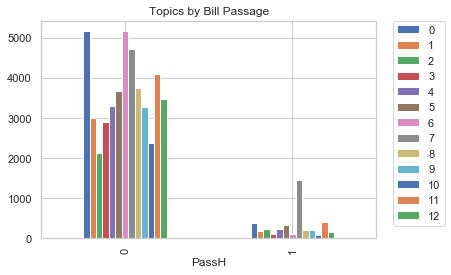

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

test.groupby(['PassH', 'dominant_topic']).size().unstack().plot.bar().set_title('Topics by Bill Passage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


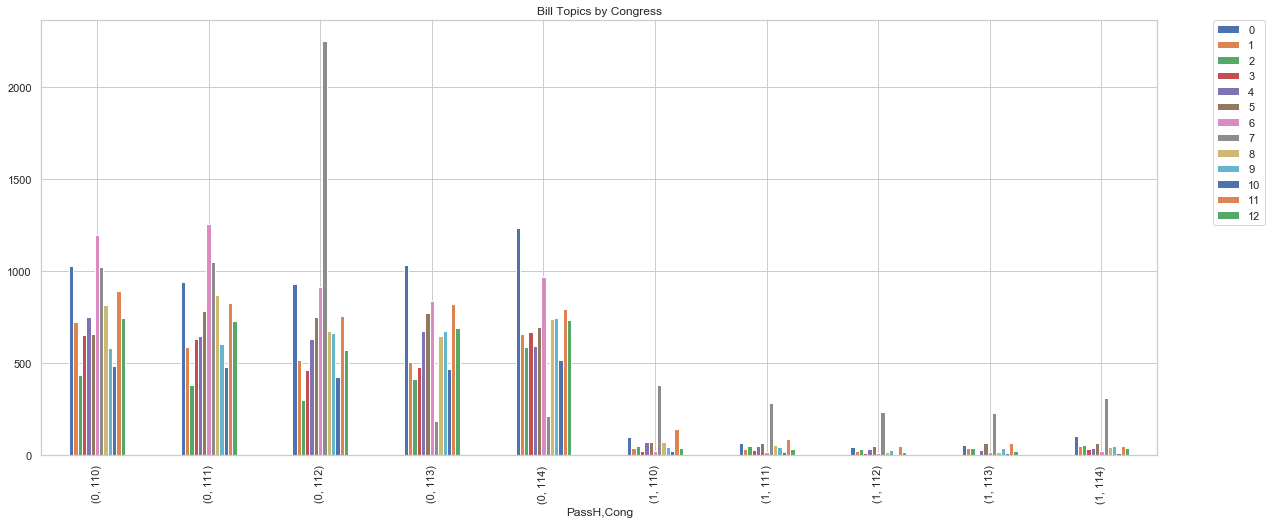

In [87]:

test.groupby(['PassH', 'Cong','dominant_topic']).size().unstack().plot.bar(figsize=(20,8)).set_title('Bill Topics by Congress')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


Text(0.5, 1.0, 'Bill Topic Percentage Proposals by Congress')

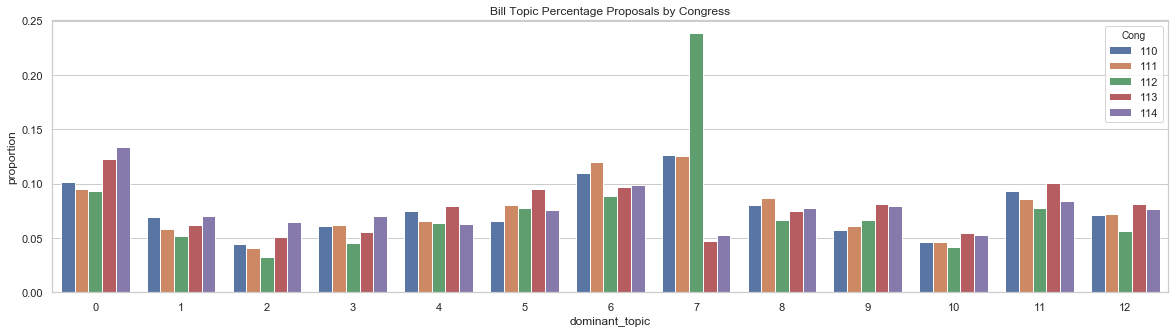

In [99]:
#Looking at dominant topic contribution by proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x1, y1, hue = "dominant_topic", "proportion", "Cong"
hue_order = ["1", "0"]
data=test

(test[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x1, y=y1, hue=hue).set_title('Bill Topic Percentage Proposals by Congress'))


In [91]:
test['dominant_topic'].head()

0     5
1    10
2     4
3    10
4     5
Name: dominant_topic, dtype: int64

Text(0.5, 1.0, 'Topic by Percent Contribution to Passage')

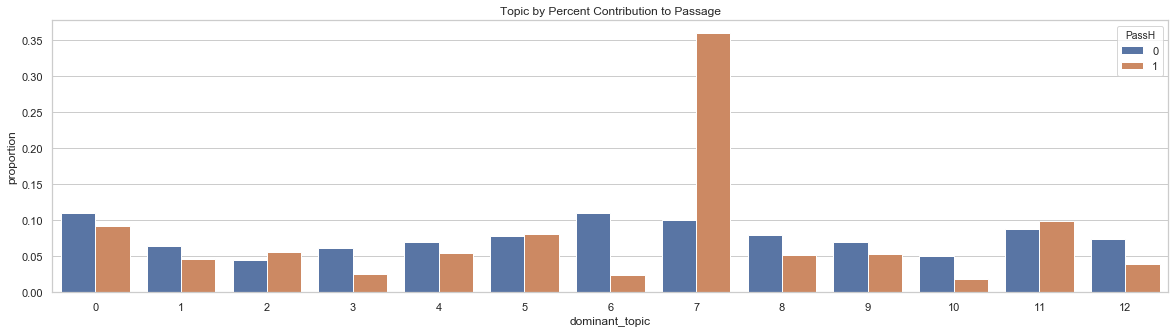

In [104]:
#Looking at dominant topic contribution by proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x1, y1, hue = "dominant_topic", "proportion", "PassH"
hue_order = ["1", "0"]
data=test

(test[x]
 .groupby(test[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x1, y=y1, hue=hue).set_title('Topic by Percent Contribution to Passage'))


Text(0.5, 1.0, 'Topic by Party Proposal Breakdown')

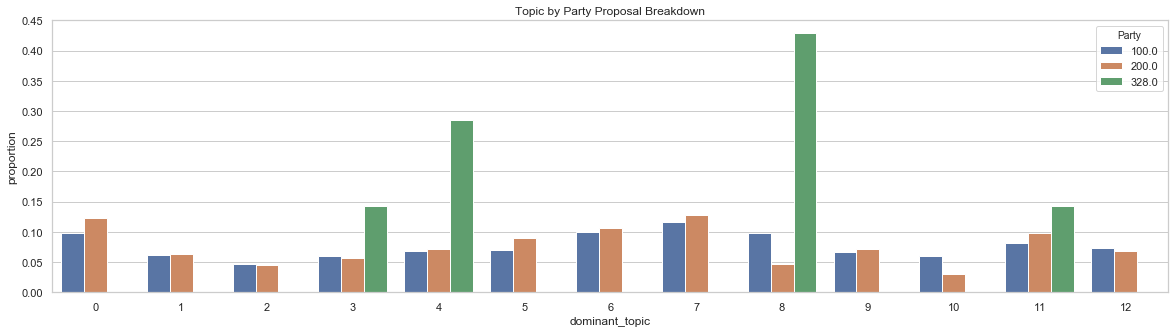

In [107]:
#Looking at dominant topic contribution by topic and party
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x1, y1, hue = "dominant_topic", "proportion", "Party"
hue_order = ["1", "0"]
data=test

(test[x]
 .groupby(test[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x1, y=y1, hue=hue).set_title('Topic by Party Proposal Breakdown'))


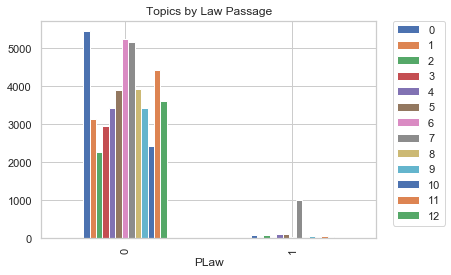

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

test.groupby(['PLaw', 'dominant_topic']).size().unstack().plot.bar().set_title('Topics by Law Passage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


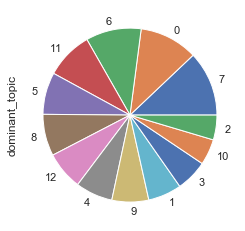

In [71]:
test['dominant_topic'].value_counts().plot.pie()

In [73]:
df_document_topic['dominant_topic'].value_counts()

7     6168
0     5544
6     5266
11    4495
5     3991
8     3962
12    3632
4     3530
9     3493
1     3180
3     3004
10    2452
2     2350
Name: dominant_topic, dtype: int64

In [74]:
print(df.shape)
print(df_document_topic.shape)

(51067, 30)
(51067, 14)


**Looking into 112th Congress Issue:**

Find a way to pull out just where PassH is true

**Save Model:**

In [52]:
import pickle

lda = pickle.dumps(best_lda_model)
lda_save = pickle.loads(lda)
lda_save.predict(X[0:1])
# array([0])
# y[0]


AttributeError: 'LatentDirichletAllocation' object has no attribute 'predict'

In [ ]:
# df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
# df_topic_distribution.columns = ['Topic Num', 'Num Documents']
# df_topic_distribution

In [ ]:
# # Show top n keywords for each topic
# def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
#     keywords = np.array(vectorizer.get_feature_names())
#     topic_keywords = []
#     for topic_weights in best_lda_model.components_:
#         top_keyword_locs = (-topic_weights).argsort()[:n_words]
#         topic_keywords.append(keywords.take(top_keyword_locs))
#     return topic_keywords

# topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# # Topic - Keywords Dataframe
# df_topic_keywords = pd.DataFrame(topic_keywords)
# df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
# df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
# df_topic_keywords

**Dominant topic visualizations**



In [ ]:
# def format_topics_sentences(ldamodel, corpus, texts):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         # print(row)
        
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(best_lda_model, transformed, vectorizer)

# # Format
# # df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)

# Adding topics to MySQL:

Create a separate table for topics and link with BillID Primary Key

https://stackoverflow.com/questions/53518217/adding-topic-distribution-outcome-of-topic-model-to-pandas-dataframe

In [ ]:
#make sure it is the right shape first!
df.shape

In [4]:
from sqlalchemy import Table, MetaData, Column, Integer, String, ForeignKey
from sqlalchemy.orm import mapper


In [5]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [6]:

# #Create Table 
# topics_table = db.Table('topics', metadata,
#     db.Column('Index', db.Integer, autoincrement=True, primary_key=True),
#     db.Column('BillID', db.String(40)),
#     db.Column('dominant_topic', db.Integer),
#     db.Column('foreign_key',
#                 db.String(40),
#                 db.ForeignKey('current_bills.BillID'),
#                 nullable=False))                       


In [7]:
topics_table = db.Table('topics', metadata,
    db.Column('Index', db.Integer, autoincrement=True, primary_key=True),
    db.Column('BillID', db.Integer, db.ForeignKey("current_bills.BillID"), nullable=False),
    db.Column('dominant_topic', db.Integer)
)

In [77]:
metadata.create_all(engine)

NoReferencedTableError: Foreign key associated with column 'topics.BillID' could not find table 'current_bills' with which to generate a foreign key to target column 'BillID'

In [ ]:
# query = db.insert(topics_table)
# connection.execute(query, bill)